### Simple example of fitting an NVP flow to a 2D dataset

Paper is [here](https://arxiv.org/pdf/1605.08803).

In [1]:
import os
import torch
from torch import nn
from torch import distributions
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from tqdm.notebook import trange

FIGS_DIR = os.path.join(os.getcwd(), "figs/moons/")
if not os.path.exists(FIGS_DIR):
    os.makedirs(FIGS_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
def convert(x):
    # Convert a numpy array to a torch tensor with float32 entries
    return torch.as_tensor(x).float()

##### Model

In [2]:
class RealNVP(nn.Module):
    def __init__(self, net_s, net_t, mask, prior):
        super(RealNVP, self).__init__()
        # Base distribution, a data-dimensional Gaussian
        self.prior = prior
        # Masks are not to be optimised
        self.mask = nn.Parameter(mask, requires_grad=False)
        # The s and t nets that parameterise the scale and shift
        # change of variables according to inputs, here we are
        # duplicating the networks for each layer.
        self.t = torch.nn.ModuleList(
            [net_t() for _ in range(len(masks))]
        )
        self.s = torch.nn.ModuleList(
            [net_s() for _ in range(len(masks))]
        )

    def reverse(self, z):
        # Map from Gaussian distributed z to data x
        x = z
        for i in range(len(self.t)):
            x_ = x * self.mask[i]
            s = self.s[i](x_) * (1 - self.mask[i])
            t = self.t[i](x_) * (1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def forward(self, x):
        # Map from data x to Gaussian distributed z
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1 - self.mask[i])
            t = self.t[i](z_) * (1 - self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

    def log_prob(self, x):
        # Calculate log-probability of x under flow distribution
        z, log_det_J = self.forward(x)
        return self.prior.log_prob(z) + log_det_J

    def sample(self, n):
        # Sample n points from flow distribution fit to data
        z = self.prior.sample((n, 1))
        x = self.reverse(z)
        return x
    

class ConditionalRealNVP(nn.Module):
    def __init__(self, net_s, net_t, mask, prior):
        super(RealNVP, self).__init__()
        # Base distribution, a data-dimensional Gaussian
        self.prior = prior
        # Masks are not to be optimised
        self.mask = nn.Parameter(mask, requires_grad=False)
        # The s and t nets that parameterise the scale and shift
        # change of variables according to inputs, here we are
        # duplicating the networks for each layer.
        self.t0 = torch.nn.ModuleList(
            [net_t() for _ in range(len(masks))]
        )
        self.t1 = torch.nn.ModuleList(
            [net_t() for _ in range(len(masks))]
        )
        
        self.s0 = torch.nn.ModuleList(
            [net_s() for _ in range(len(masks))]
        )
        self.s1 = torch.nn.ModuleList(
            [net_s() for _ in range(len(masks))]
        )

    def reverse(self, z, label):
        # Map from Gaussian distributed z to data x
        x = z
        if label==0:
            for i in range(len(self.t)):
                x_ = x * self.mask[i]
                s = self.s0[i](x_) * (1 - self.mask[i])
                t = self.t0[i](x_) * (1 - self.mask[i])
                x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        else:
            for i in range(len(self.t)):
                x_ = x * self.mask[i]
                s = self.s1[i](x_) * (1 - self.mask[i])
                t = self.t1[i](x_) * (1 - self.mask[i])
                x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def forward(self, x, label):
        # Map from data x to Gaussian distributed z
        log_det_J, z = x.new_zeros(x.shape[0]), x
        if label==0:
            for i in reversed(range(len(self.t))):
                z_ = self.mask[i] * z
                s = self.s0[i](z_) * (1 - self.mask[i])
                t = self.t0[i](z_) * (1 - self.mask[i])
                z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
                log_det_J -= s.sum(dim=1)
        else:
            for i in reversed(range(len(self.t))):
                z_ = self.mask[i] * z
                s = self.s1[i](z_) * (1 - self.mask[i])
                t = self.t1[i](z_) * (1 - self.mask[i])
                z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
                log_det_J -= s.sum(dim=1)
        return z, log_det_J

    def log_prob(self, x, label):
        # Calculate log-probability of x under flow distribution
        z, log_det_J = self.forward(x, label)
        return self.prior.log_prob(z) + log_det_J

    def sample(self, n0, n1):
        # Sample n0 points of label 0 and n1 points of label 1 from flow distribution fit to data
        z0 = self.prior.sample((n0, 1))
        z1 = self.prior.sample((n1, 1))
        x = torch.cat(self.reverse(z0,0),self.reverse(z1,1))
        return x

##### Setup

In [3]:
H = 256            # Hidden dimension
L = 4              # Number of transforms in flow
n_data = 10000     # Number of datapoints in training set
n_steps = 10000    # Number of batches to run for
batch_size = 1000  # Number of datapoints in batch

# Scaling and shifting networks for flow change of variables
net_s = lambda: nn.Sequential(
    nn.Linear(2, H), nn.LeakyReLU(),
    nn.Linear(H, H), nn.LeakyReLU(),
    nn.Linear(H, 2), nn.Tanh()
)
net_t = lambda: nn.Sequential(
    nn.Linear(2, H), nn.LeakyReLU(),
    nn.Linear(H, H), nn.LeakyReLU(),
    nn.Linear(H, 2)
)

# Masking for NVP flow model
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * L)).float()

# Base distribution for normalizing flow
prior = distributions.MultivariateNormal(
    torch.zeros(2).to(device), torch.eye(2).to(device)
)

# Build the model
flow = RealNVP(net_s, net_t, masks, prior).to(device)

# Get some training data
X, Y = make_moons(n_data, noise=0.05)

# Scale the data to [-1, 1]
X = 2. * (X - X.min()) / (X.max() - X.min()) - 1.

# Convert it to tensors and move to device
X, Y = convert(X).to(device), convert(Y).to(device)

def get_data(n_batch):
    # A simple dataloader
    ix = torch.randint(low=0, high=n_data, size=(n_batch,))
    x, y = X[ix], Y[ix]
    return x, y

optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4)

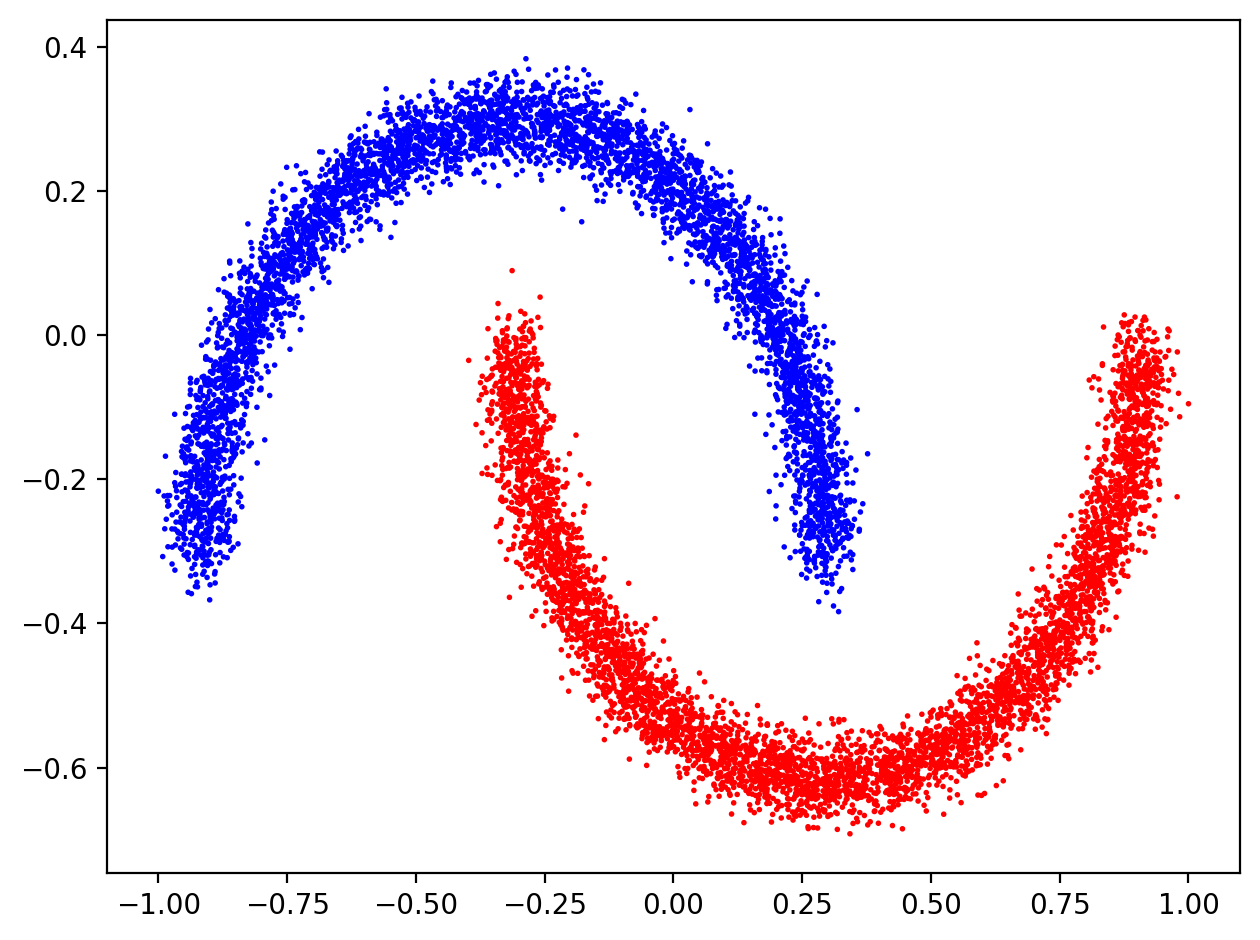

In [4]:
# Plot some training samples for comparison
fig, ax = plt.subplots(1, 1, dpi=200)
ax.scatter(*X.cpu().numpy().T, c=Y.cpu().numpy(), s=1., cmap="bwr")
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "train_samples_moons.png"))
plt.show()

#### Train

  0%|          | 0/10000 [00:00<?, ?it/s]

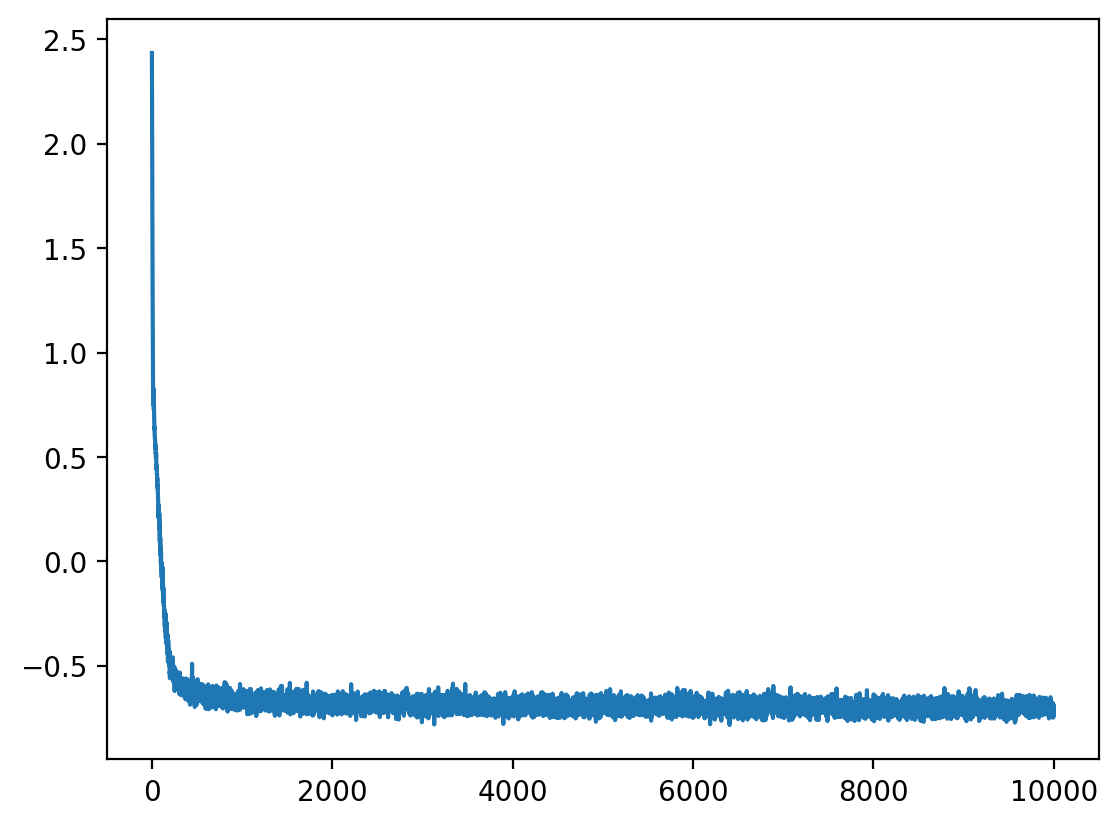

In [4]:
losses = []
with trange(n_steps) as T:
    for t in T:
        x, _ = get_data(batch_size)
        x = x.to(device)
        
        loss = -flow.log_prob(x).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        T.set_postfix(loss=f"{loss:.3E}")

        if t % 500 == 0:
            # Sample from the flow
            samples = flow.sample(2000)
            samples = samples.cpu().detach().numpy()

            fig, ax = plt.subplots(1, 1, dpi=100)
            ax.scatter(*samples.T, s=1.)
            plt.tight_layout()
            plt.savefig(os.path.join(FIGS_DIR, "flow_samples_moons.png"))
            plt.close()

# Plot losses as we go
plt.figure(dpi=200)
plt.plot(losses)
plt.savefig(os.path.join(FIGS_DIR, "loss_nvp_moons.png"))
plt.show()

#### Validate

In [31]:
from torch.utils.data import TensorDataset, DataLoader

n_val_data = 1000

# Get some validation data
X_val, Y_val = make_moons(n_val_data, noise=0.05)

# Scale the data to [-1, 1]
X_val = 2. * (X_val - X_val.min()) / (X_val.max() - X_val.min()) - 1.

# Convert it to tensors and move to device
X_val, Y_val = convert(X_val).to(device), convert(Y_val).to(device)

val_dataset = TensorDataset(X_val, Y_val)

In [32]:
batch_size = 8
val_dataloader = DataLoader(val_dataset, batch_size, drop_last = True)
n_batches = len(val_dataloader)
with trange(n_batches) as T:
    with torch.no_grad():
        running_loss = 0
        for (batch,t) in zip(val_dataloader,T):
            x, _ = batch
            x = x.to(device)
            
            loss = -flow.log_prob(x).mean()

            running_loss+= loss.item()
            T.set_postfix(loss=f"{running_loss/(t+1):.3E}")

        final_loss = running_loss/n_batches

        # Sample from the flow
        samples = flow.sample(2000)
        samples = samples.cpu().detach().numpy()

        fig, ax = plt.subplots(1, 1, dpi=100)
        ax.scatter(*samples.T, s=1.)
        plt.tight_layout()
        plt.savefig(os.path.join(FIGS_DIR, "flow_val_samples_moons.png"))
        plt.close()

print(f"Validation Loss: {final_loss}")

  0%|          | 0/125 [00:00<?, ?it/s]

Validation Loss: -0.19838520789146424


#### Inference

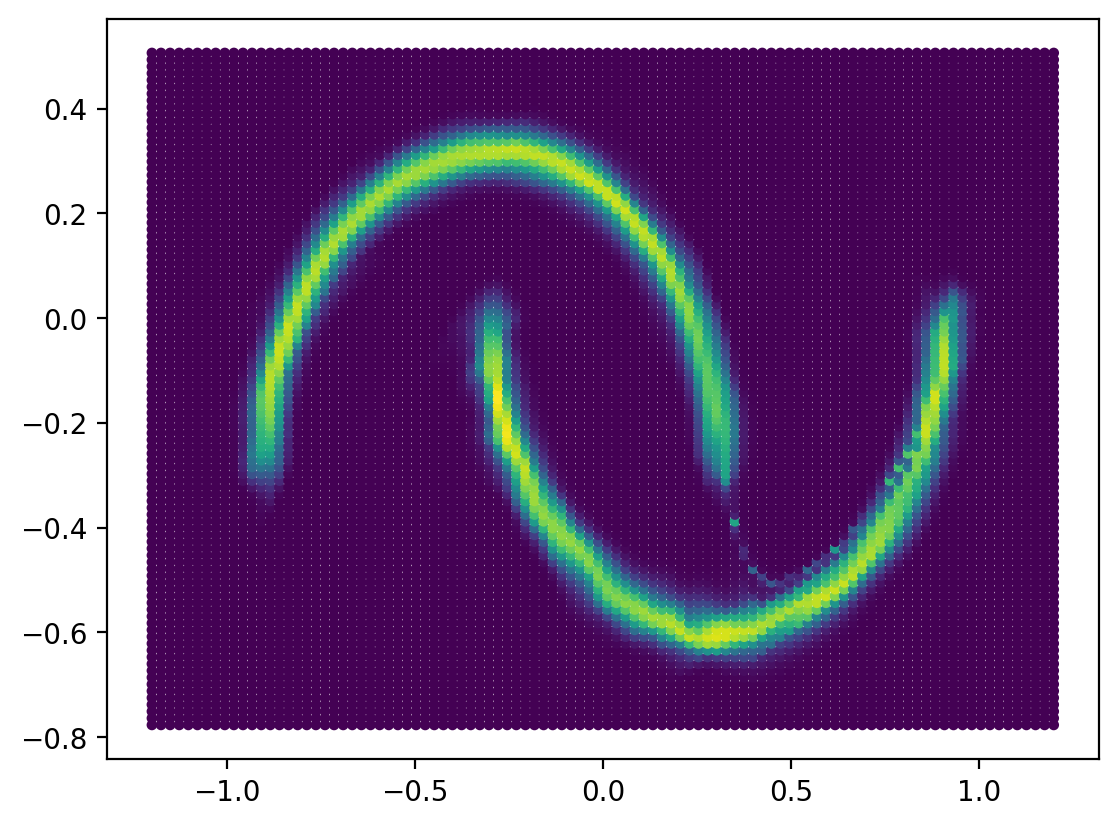

In [5]:
# Plot the likelihood over data space
X, Y = make_moons(n_data, noise=0.05)
X = 2. * (X - X.min()) / (X.max() - X.min()) - 1.

# Get a grid of points spanning the data space
X1, X2 = X.T
dx = 0.1 * (X1.max() - X1.min()) # Same span as data plus a little bit extra
dy = 0.1 * (X2.max() - X2.min())
X_, Y_ = np.mgrid[X1.min() - dx:X1.max() + dx:100j, X2.min() - dy:X2.max() + dy:100j]
X = torch.as_tensor(np.vstack([X_.ravel(), Y_.ravel()])).float().T

# Flow likelihood
L_x = np.exp(flow.log_prob(X.to(device)).cpu().detach().numpy())

plt.figure(dpi=200)
plt.scatter(*X.numpy().T, c=L_x, s=8.)
plt.savefig(os.path.join(FIGS_DIR, "likelihood_moons.png"))
plt.show()

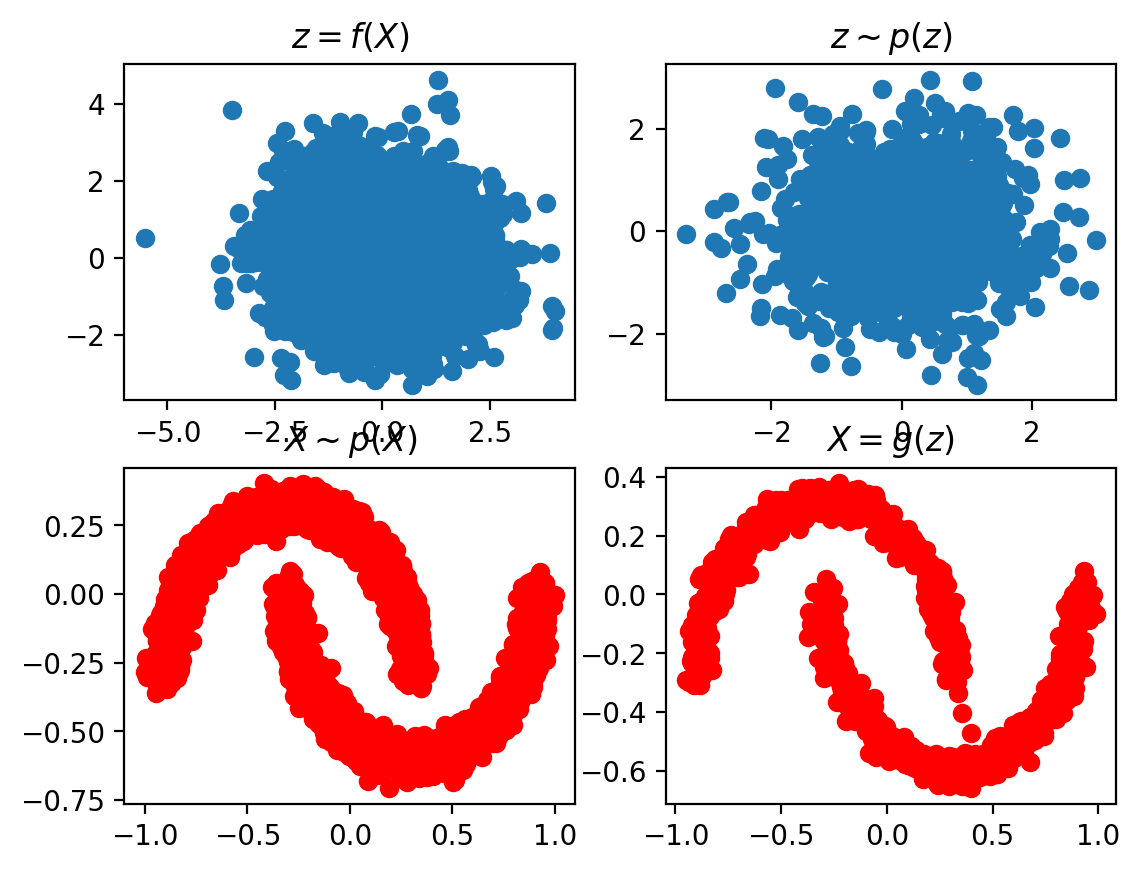

In [6]:
X, Y = make_moons(n_data, noise=0.05)
X = 2. * (X - X.min()) / (X.max() - X.min()) - 1.

X = torch.as_tensor(X).float().to(device)

plt.figure(dpi=200)

# Data mapped to prior 'latent' space
z = flow.forward(X)[0].cpu().detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

# Prior
z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

# Truth distribution
plt.subplot(223)
X = X.cpu()
plt.scatter(X[:, 0], X[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

# Generated
plt.subplot(224)
X = flow.sample(1000).cpu().detach().numpy().squeeze()
plt.scatter(X[:, 0], X[:, 1], c='r')
plt.title(r'$X = g(z)$')

plt.savefig(os.path.join(FIGS_DIR, "flow_mappings.png"))
plt.show()